In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

first_row = session.query(Measurement).first()
first_row.__dict__

first_row_1 = session.query(Station).first()
first_row_1.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1094716a0>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0}

In [12]:
results = session.query(Measurement, Station).all()

# Exploratory Climate Analysis

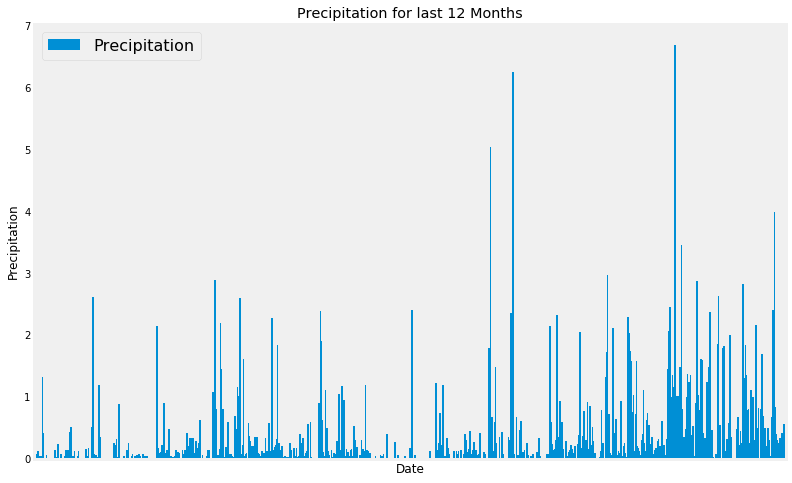

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
engine.execute('SELECT * FROM Measurement').fetchall()

# Calculate the date 1 year ago from the last data point in the database

last_data_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_data_point

# Perform a query to retrieve the data and precipitation scores

results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23').all()

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True, )

# Sort the dataframe by date
df.sort_values(by='Date').head()

# Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot(kind='bar', width=5, figsize=(12,8))
plt.grid()
plt.title("Precipitation for last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.legend(fontsize="16")
plt.xticks([])
plt.show()

![precipitation](Images/precipitation.png)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data

df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [15]:
# Design a query to show how many stations are available in this dataset?
len(engine.execute('SELECT * FROM Station').fetchall())

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

most_active_station = active_stations[0]
most_active_station

('USC00519281', 2772)

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

station_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station[0]).all()
station_temps

[(54.0, 85.0, 71.66378066378067)]

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_observs = session.query(Measurement.tobs).filter(Measurement.station == most_active_station[0]).filter(Measurement.date >= '2016-08-24').all()
temp_observs

new_df = pd.DataFrame(temp_observs)

new_df.head()

,tobs
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0


<function matplotlib.pyplot.show(*args, **kw)>

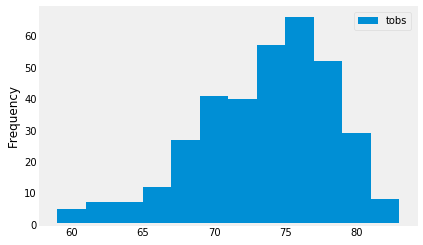

In [19]:
#plot histogram hereeeee

new_df.plot.hist(bins=12)
#plt.hist(temp_observs[0], bins=12, figsize=(12,8))
plt.grid()
plt.show

![precipitation](Images/station-histogram.png)

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_start_prev_year = '2017-03-01'
trip_end_prev_year = '2017-03-15'

Calc_temps = calc_temps(trip_start_prev_year, trip_end_prev_year)
print(Calc_temps)


[(62.0, 71.1086956521739, 82.0)]


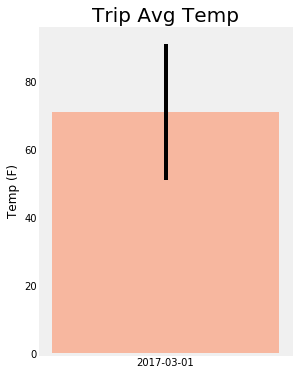

In [73]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

t_max = Calc_temps[0][2]
t_min = Calc_temps[0][0]

yerr = t_max - t_min
plt.figure(figsize=(4,6))
plt.bar(trip_start_prev_year, Calc_temps[0][1], alpha=0.5, color='coral', yerr=yerr, )
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.grid()

In [33]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_per_station = session.query(Station.station, func.sum(Measurement.prcp), Station.name,
                                    Station.elevation, Station.latitude, Station.longitude).filter(Measurement.station==Station.station)\
.filter(Measurement.date >= trip_start_prev_year)\
.filter(Measurement.date <= trip_end_prev_year)\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc()).all()

for x in rainfall_per_station:
    print (x)

('USC00513117', 5.76, 'KANEOHE 838.1, HI US', 14.6, 21.4234, -157.8015)
('USC00519281', 5.46, 'WAIHEE 837.5, HI US', 32.9, 21.45167, -157.84888999999998)
('USC00516128', 3.5, 'MANOA LYON ARBO 785.2, HI US', 152.4, 21.3331, -157.8025)
('USC00517948', 3.04, 'PEARL CITY, HI US', 11.9, 21.3934, -157.9751)
('USC00519397', 2.7399999999999998, 'WAIKIKI 717.2, HI US', 3.0, 21.2716, -157.8168)
('USC00519523', 2.32, 'WAIMANALO EXPERIMENTAL FARM, HI US', 19.5, 21.33556, -157.71139)
('USC00514830', 1.75, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 7.0, 21.5213, -157.8374)


## Optional Challenge Assignment

In [35]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [38]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
    
# Set the start and end date of the trip

trip_start_prev_year = '2017-03-01'
trip_end_prev_year = '2017-03-15'

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

lst = ["03-01", "03-02", "03-03", "03-04", "03-05", "03-06", "03-07", "03-08", "03-09", "03-10", "03-11", "03-12", "03-13", "03-14", "03-15"]

# Loop through the list of %m-%d strings and calculate the normals for each date

normals = []

for x in lst:
    normals.append(daily_normals(x))

print(normals)


[[(64.0, 70.0327868852459, 76.0)], [(61.0, 70.36666666666666, 78.0)], [(60.0, 70.06896551724138, 78.0)], [(57.0, 69.27272727272727, 77.0)], [(60.0, 67.89090909090909, 76.0)], [(60.0, 69.20338983050847, 76.0)], [(60.0, 69.17241379310344, 78.0)], [(59.0, 68.72413793103448, 78.0)], [(57.0, 68.56140350877193, 75.0)], [(57.0, 69.12280701754386, 75.0)], [(60.0, 69.89285714285714, 82.0)], [(62.0, 69.88888888888889, 80.0)], [(56.0, 69.29629629629629, 77.0)], [(62.0, 70.32758620689656, 77.0)], [(58.0, 68.54716981132076, 76.0)]]


In [47]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

tmin = []
tavg = []
tmax = []

for x in normals:
    tmin.append(x[0][0])
    tavg.append(x[0][1])
    tmax.append(x[0][2])
    

df = pd.DataFrame({"Date": lst, "TMIN": tmin, "TAVG": tavg, "TMAX": tmax})

df


,Date,TMIN,TAVG,TMAX
0,03-01,64.0,70.032787,76.0
1,03-02,61.0,70.366667,78.0
2,03-03,60.0,70.068966,78.0
3,03-04,57.0,69.272727,77.0
4,03-05,60.0,67.890909,76.0
5,03-06,60.0,69.203390,76.0
6,03-07,60.0,69.172414,78.0
7,03-08,59.0,68.724138,78.0
8,03-09,57.0,68.561404,75.0
9,03-10,57.0,69.122807,75.0


[Text(0,0,'03-01'),
 Text(0,0,'03-02'),
 Text(0,0,'03-03'),
 Text(0,0,'03-04'),
 Text(0,0,'03-05'),
 Text(0,0,'03-06'),
 Text(0,0,'03-07'),
 Text(0,0,'03-08'),
 Text(0,0,'03-09'),
 Text(0,0,'03-10')]

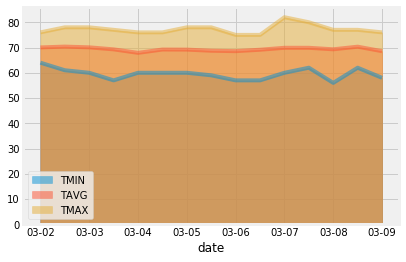

In [90]:
# Plot the daily normals as an area plot with `stacked=False`

ax = df.plot.area(stacked=False)
plt.xlabel("date")
ax.set_xticklabels(df["Date"])


